# Imports

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

#Time Series

Date
1901-01-01     37.1
1901-02-01     58.4
1901-03-01      3.9
1901-04-01     64.1
1901-05-01    121.7
              ...  
2015-08-01    260.6
2015-09-01    164.0
2015-10-01     32.7
2015-11-01      2.3
2015-12-01      6.3
Name: Rain, Length: 1380, dtype: float64


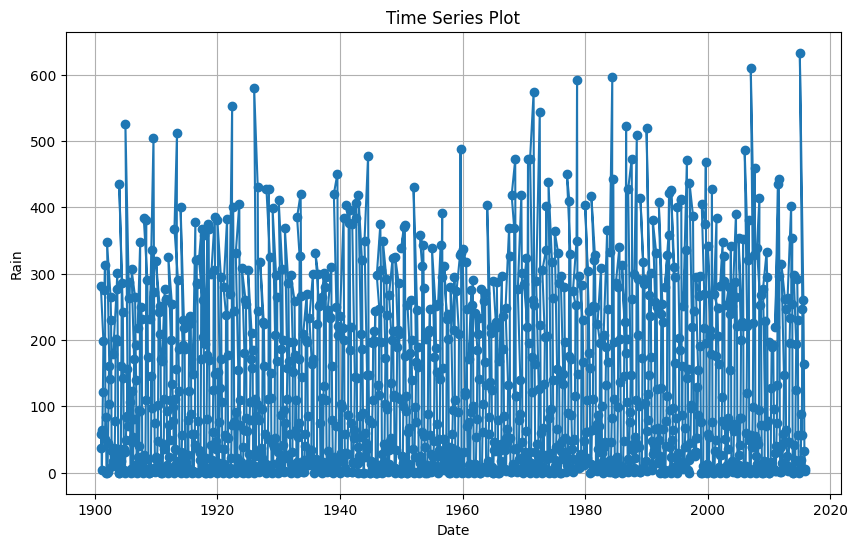

In [239]:
file_path = '/content/GARCHdata.xlsx'


def month_to_number(month):
    month_mapping = {
        'JAN': '01', 'FEB': '02', 'MAR': '03', 'APR': '04', 'MAY': '05', 'JUN': '06',
        'JUL': '07', 'AUG': '08', 'SEP': '09', 'OCT': '10', 'NOV': '11', 'DEC': '12'
    }
    return month_mapping.get(month.upper(), '01')

try:

    rain_data = pd.read_excel(file_path)

    rain_data['Month'] = rain_data['Month'].apply(month_to_number)


    rain_data['Date'] = pd.to_datetime(rain_data[['YEAR', 'Month']].astype(str).agg('-'.join, axis=1))


    rain_data.set_index('Date', inplace=True)
    rain_data.drop(columns=['YEAR', 'Month'], inplace=True)


    data_ts = pd.Series(rain_data['Rain'])


    print(data_ts)


    plt.figure(figsize=(10, 6))
    plt.plot(data_ts.index, data_ts, marker='o', linestyle='-')
    plt.xlabel('Date')
    plt.ylabel('Rain')
    plt.title('Time Series Plot')
    plt.grid(True)
    plt.show()

except Exception as e:
    print("Error:", e)


In [240]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_ts)


test_statistic = result[0]
p_value = result[1]

print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")


if p_value <= 0.05:
    print("The data is stationary (reject the null hypothesis of non-stationarity).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis of non-stationarity).")


Test Statistic: -6.2108796253540115
P-value: 5.511656841234457e-08
The data is stationary (reject the null hypothesis of non-stationarity).


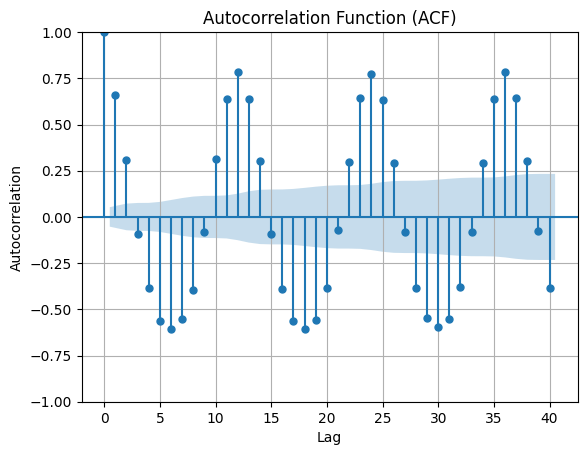

In [241]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data_ts, lags=40)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


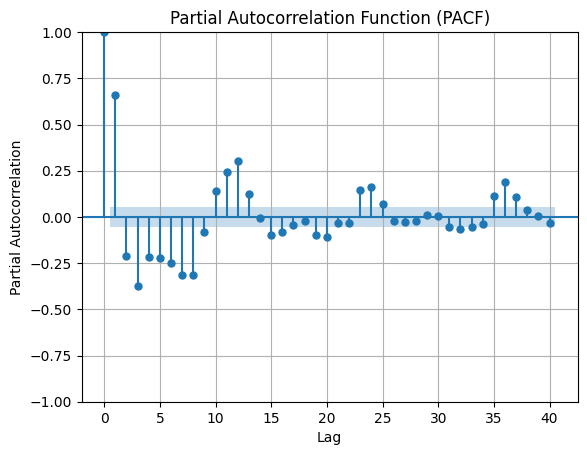

In [242]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data_ts, lags=40)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()


In [243]:
!pip install pmdarima


In [244]:
from pmdarima.arima.utils import ndiffs

num_diffs = ndiffs(data_ts, test='adf')


print(f"Number of differences required: {num_diffs}")


Number of differences required: 0


In [245]:
from pmdarima.arima.utils import nsdiffs

seasonal_period = 4

ns_diffs = nsdiffs(data_ts, m=seasonal_period)

print(f"Number of seasonal differences required: {num_diffs}")

Number of seasonal differences required: 0


# ARIMA

In [246]:
import pandas as pd
import statsmodels.api as sm

train_size = int(len(data_ts) * 0.8)
train_data, test_data = data_ts[:train_size], data_ts[train_size:]

order = (1, 0, 2)
arima_model = sm.tsa.ARIMA(train_data, order=order)
arima_result = arima_model.fit()

print(arima_result.summary())

predicted_values = arima_result.predict(start=len(train_data), end=len(data_ts)-1, dynamic=False)

print("Predicted Values:")
print(predicted_values)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

                               SARIMAX Results                                
Dep. Variable:                   Rain   No. Observations:                 1104
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -6574.440
Date:                Fri, 28 Jul 2023   AIC                          13158.880
Time:                        19:10:37   BIC                          13183.914
Sample:                             0   HQIC                         13168.349
                               - 1104                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        122.2534     11.225     10.892      0.000     100.254     144.253
ar.L1          0.4006      0.063      6.332      0.000       0.277       0.525
ma.L1          0.3683      0.061      6.064      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


# SARIMA 1

order = (1, 0, 2)
seasonal_order = (1, 1, 2)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

                                     SARIMAX Results                                      
Dep. Variable:                               Rain   No. Observations:                 1380
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood               -7600.974
Date:                            Fri, 28 Jul 2023   AIC                          15215.949
Time:                                    19:11:22   BIC                          15252.496
Sample:                                         0   HQIC                         15229.627
                                           - 1380                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5074      0.830     -0.611      0.541      -2.135       1.120
ma.L1          0.5474      0.831   

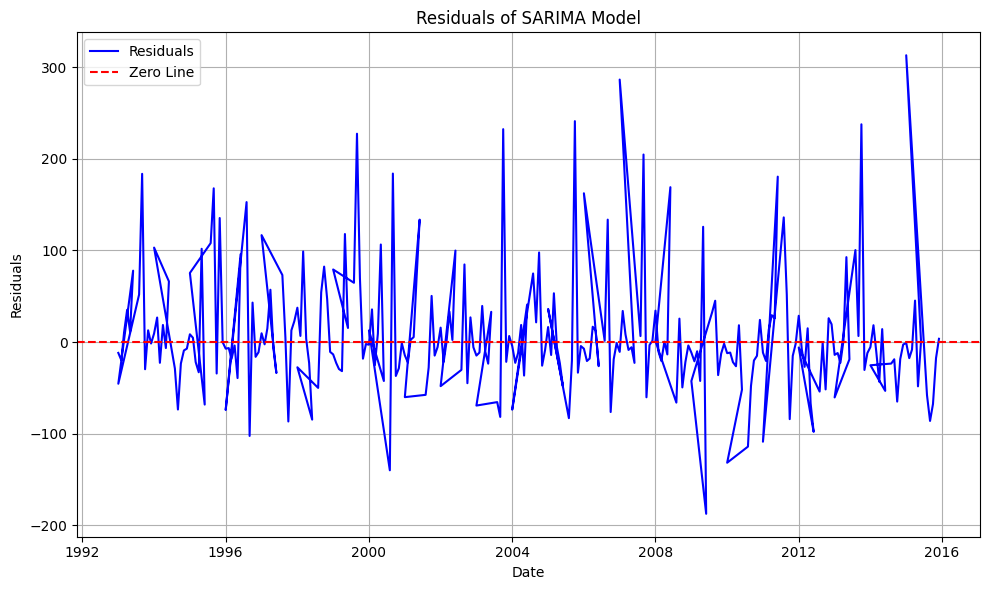

In [247]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

seasonal_period = 12

order = (1, 0, 2)
seasonal_order = (1, 1, 2, seasonal_period)

rain_model1 = sm.tsa.statespace.SARIMAX(data_ts, order=order, seasonal_order=seasonal_order)
result = rain_model1.fit()

print(result.summary())

train_size = int(len(data_ts) * 0.8)
fitted_values = result.fittedvalues
train_fitted, test_fitted = fitted_values[:train_size], fitted_values[train_size:]

residuals = data_ts[train_size:] - test_fitted

residuals_df = pd.DataFrame(residuals, index=data_ts[train_size:].index, columns=["Residuals"])

plt.figure(figsize=(10, 6))
plt.plot(residuals_df.index, residuals_df["Residuals"], color='b', label='Residuals')
plt.axhline(0, color='r', linestyle='--', label='Zero Line')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of SARIMA Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [248]:
h = len(test_data)
forecast_result = result.get_forecast(steps=h)
forecast_values = forecast_result.predicted_mean
confidence_intervals = forecast_result.conf_int()

print("Forecasted Values:")
print(forecast_values)
print("\nConfidence Intervals:")
print(confidence_intervals)

Forecasted Values:
1380     12.454257
1381     21.313684
1382     30.003548
1383     45.702345
1384    110.938878
           ...    
1651    312.245002
1652    245.893833
1653    116.550323
1654     21.506233
1655      5.730132
Name: predicted_mean, Length: 276, dtype: float64

Confidence Intervals:
      lower Rain  upper Rain
1380 -108.298244  133.206758
1381  -99.535451  142.162819
1382  -90.894433  150.901528
1383  -75.208208  166.612899
1384   -9.974913  231.852668
...          ...         ...
1651  191.239242  433.250761
1652  124.888073  366.899593
1653   -4.455435  237.556082
1654  -99.499522  142.511988
1655 -115.275616  126.735880

[276 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


# Garch 1

In [249]:
!pip install arch

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.723e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 7120.312741655466
Iteration:      2,   Func. Count:     13,   Neg. LLF: 6961.294551674845
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6938.182722073176
Iteration:      4,   Func. Count:     24,   Neg. LLF: 6931.350383812052
Iteration:      5,   Func. Count:     29,   Neg. LLF: 6912.370250925067
Iteration:      6,   Func. Count:     34,   Neg. LLF: 6908.820306716874
Iteration:      7,   Func. Count:     39,   Neg. LLF: 6908.1928231640995
Iteration:      8,   Func. Count:     44,   Neg. LLF: 6907.897020536788
Iteration:      9,   Func. Count:     49,   Neg. LLF: 6906.904064105745
Iteration:     10,   Func. Count:     54,   Neg. LLF: 6906.512590257814
Iteration:     11,   Func. Count:     59,   Neg. LLF: 6906.492489367632
Iteration:     12,   Func. Count:     64,   Neg. LLF: 6906.492098414751
Iteration:     13,   Func. Count:     69,   Neg. LLF: 6906.492083237899
Iteration:     14,   Func. Count:     74,   Neg. LLF: 6906.4919

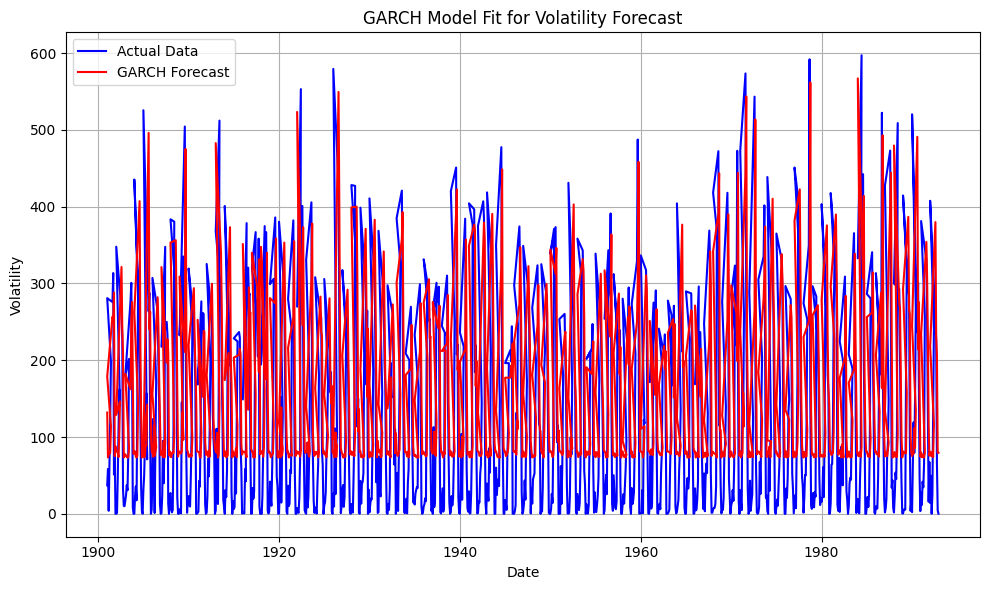

In [250]:
import arch

seasonal_period = 12

train_size = int(len(data_ts) * 0.8)
train_data, test_data = data_ts[:train_size], data_ts[train_size:]

garch_model = arch.arch_model(train_data, p=1, q=1, vol='Garch')
garch_result = garch_model.fit()

print(garch_result.summary())

forecast_volatility = garch_result.conditional_volatility

plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data.values, label='Actual Data', color='blue')
plt.plot(forecast_volatility.index, forecast_volatility.values, label='GARCH Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('GARCH Model Fit for Volatility Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# SARIMA 2

order = (1, 0, 2)
seasonal_order = (1, 0, 2)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                               Rain   No. Observations:                 1380
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood               -7685.116
Date:                            Fri, 28 Jul 2023   AIC                          15384.231
Time:                                    19:18:31   BIC                          15420.840
Sample:                                         0   HQIC                         15397.926
                                           - 1380                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9967      0.007    140.394      0.000       0.983       1.011
ma.L1         -0.9501      0.014   

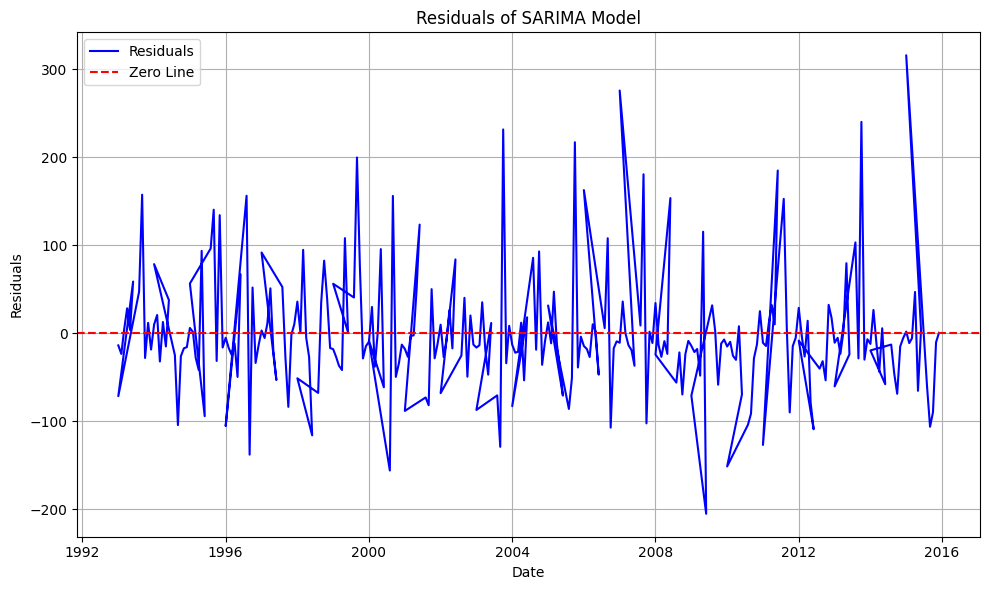

In [254]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

seasonal_period = 12

order = (1, 0, 2)
seasonal_order = (1, 0, 2, seasonal_period)

rain_model1 = sm.tsa.statespace.SARIMAX(data_ts, order=order, seasonal_order=seasonal_order)
result = rain_model1.fit()

print(result.summary())

train_size = int(len(data_ts) * 0.8)
fitted_values = result.fittedvalues
train_fitted, test_fitted = fitted_values[:train_size], fitted_values[train_size:]

residuals = data_ts[train_size:] - test_fitted

residuals_df = pd.DataFrame(residuals, index=data_ts[train_size:].index, columns=["Residuals"])

plt.figure(figsize=(10, 6))
plt.plot(residuals_df.index, residuals_df["Residuals"], color='b', label='Residuals')
plt.axhline(0, color='r', linestyle='--', label='Zero Line')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of SARIMA Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [255]:
h = len(test_data)
forecast_result = result.get_forecast(steps=h)
forecast_values = forecast_result.predicted_mean
confidence_intervals = forecast_result.conf_int()

print("Forecasted Values:")
print(forecast_values)
print("\nConfidence Intervals:")
print(confidence_intervals)

Forecasted Values:
1380     11.483546
1381     16.626813
1382     25.259570
1383     44.465384
1384    117.277384
           ...    
1651    291.297941
1652    253.457138
1653    114.038843
1654     14.574260
1655      5.952329
Name: predicted_mean, Length: 276, dtype: float64

Confidence Intervals:
      lower Rain  upper Rain
1380 -111.542248  134.509339
1381 -106.532271  139.785898
1382  -97.900635  148.419774
1383  -78.695933  167.626701
1384   -5.885037  240.439806
...          ...         ...
1651  159.625156  422.970726
1652  121.782084  385.132193
1653  -17.638466  245.716152
1654 -117.105288  146.253809
1655 -125.729443  137.634102

[276 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


# GARCH 2

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.723e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 7120.312741655466
Iteration:      2,   Func. Count:     13,   Neg. LLF: 6961.294551674845
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6938.182722073176
Iteration:      4,   Func. Count:     24,   Neg. LLF: 6931.350383812052
Iteration:      5,   Func. Count:     29,   Neg. LLF: 6912.370250925067
Iteration:      6,   Func. Count:     34,   Neg. LLF: 6908.820306716874
Iteration:      7,   Func. Count:     39,   Neg. LLF: 6908.1928231640995
Iteration:      8,   Func. Count:     44,   Neg. LLF: 6907.897020536788
Iteration:      9,   Func. Count:     49,   Neg. LLF: 6906.904064105745
Iteration:     10,   Func. Count:     54,   Neg. LLF: 6906.512590257814
Iteration:     11,   Func. Count:     59,   Neg. LLF: 6906.492489367632
Iteration:     12,   Func. Count:     64,   Neg. LLF: 6906.492098414751
Iteration:     13,   Func. Count:     69,   Neg. LLF: 6906.492083237899
Iteration:     14,   Func. Count:     74,   Neg. LLF: 6906.4919

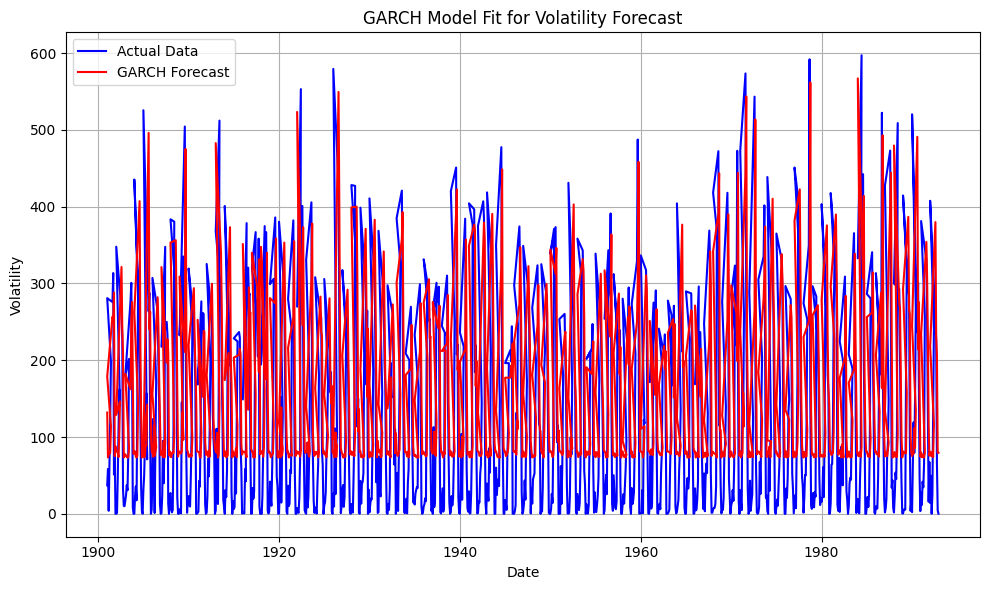

In [256]:
import arch

seasonal_period = 12

train_size = int(len(data_ts) * 0.8)
train_data, test_data = data_ts[:train_size], data_ts[train_size:]

garch_model = arch.arch_model(train_data, p=1, q=1, vol='Garch')
garch_result = garch_model.fit()

print(garch_result.summary())

forecast_volatility = garch_result.conditional_volatility

plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data.values, label='Actual Data', color='blue')
plt.plot(forecast_volatility.index, forecast_volatility.values, label='GARCH Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('GARCH Model Fit for Volatility Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
